In [1]:
import itertools
import time
import numpy as np
import pandas as pd
# import seaborn as sns
# import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
class DataGenerator:
    def __init__(self, *args, **kwargs):
        # data params
        self.ndim = kwargs.get('ndim', 30)
        self.ndata = kwargs.get('ndata', 300)
        
        # x params
        self.mu_x = kwargs.get('mu_x', np.zeros(self.ndim))
        cov = 0.85 * np.ones((self.ndim, self.ndim))
        np.fill_diagonal(cov, 1)
        self.cov_x = kwargs.get('cov_x', cov)
        
        # beta params
        self.num_choice = kwargs.get('num_choice', 10)
        self.mu_b = kwargs.get('mu_b', 0.0)
        self.var_b = kwargs.get('var_b', 0.4)
        
        # noise params
        self.mu_n = kwargs.get('mu_n', 0)
        self.var_n = kwargs.get('var_n', 6.25)
    
    def get_x(self):
        x = np.random.multivariate_normal(self.mu_x, self.cov_x, self.ndata)
#         x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
        return x
    
    def get_beta(self):
        beta = np.zeros(self.ndim)
        beta_index = np.arange(self.ndim)
#         self.choice_index = np.random.choice(beta_index, self.num_choice)
        self.choice_index = np.arange(10)
        for idx in self.choice_index:
            beta[idx] = np.random.normal(self.mu_b, np.sqrt(self.var_b), 1)
        
        return beta

    def get_noise(self):
        return np.random.normal(self.mu_n, np.sqrt(self.var_n), self.ndata)
    
    def get_y(self, x, beta):
        noise = self.get_noise()
        y = x @ beta + noise
        self._get_noise_var(y, noise)
        
        return y
    
    def _get_noise_var(self, y, noise):
        self.sn = np.var(y) / np.var(noise)
    
    def generate(self):
        x = self.get_x()
        beta = self.get_beta()
        y = self.get_y(x, beta)
        return x, y, beta

In [47]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
#     RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    RSS = (Y - model_k.predict(X)).T @ (Y - model_k.predict(X))
    R_squared = model_k.score(X,Y)
    return RSS, R_squared, model_k.coef_, model_k.intercept_

In [48]:
datagen = DataGenerator()
x, y, beta = datagen.generate()

In [54]:
subsets = np.arange(0, x.shape[1])

RSS_list, R_squared_list, feature_list, num_features, beta, beta_0 = [], [], [], [], [], []
for subset in subsets:
    for combo in itertools.combinations(subsets, subset + 1):
        RSS, R_squared, beta_temp, beta_0_temp = fit_linear_reg(x[:, list(combo)], y)
        RSS_list.append(RSS)                  #Append lists
        R_squared_list.append(R_squared)
        feature_list.append(combo)
        num_features.append(len(combo)) 
        beta.append(beta_temp)
        beta_0.append(beta_0_temp)
    break

df = pd.DataFrame(
    {
        'num_features': num_features,
        'RSS': RSS_list, 
        'R_squared':R_squared_list,
        'features':feature_list, 
        'beta': beta, 
        'beta_0': beta_0
    }
)

In [59]:
df_min = df[df.groupby('num_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('num_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,num_features,RSS,R_squared,features,beta,beta_0,min_RSS,max_R_squared
0,1,2039.620212,0.065016,"(0,)",[-0.6668262419830246],-0.342709,2039.620212,0.065016


,num_features,RSS,R_squared,features,beta,beta_0,min_RSS,max_R_squared
0,1,2039.620212,0.065016,"(0,)",[-0.6668262419830246],-0.342709,2039.620212,0.065016


In [70]:
# df['min_RSS'] = df.groupby('num_features')['RSS'].transform(min)
# df['max_R_squared'] = df.groupby('num_features')['R_squared'].transform(max)
# df
print(beta)
print(df_min['beta'])
mean_squared_error(beta[0] ,df_min['beta'])

[array([-0.66682624]), array([-0.59733567]), array([-0.43236819]), array([-0.57642549]), array([-0.63051507]), array([-0.57164518]), array([-0.56601625]), array([-0.43457078]), array([-0.60556051]), array([-0.65848095]), array([-0.52802694]), array([-0.52294494]), array([-0.4386918]), array([-0.48039476]), array([-0.55356634]), array([-0.53788763]), array([-0.4452014]), array([-0.58395381]), array([-0.53768508]), array([-0.47324494]), array([-0.56869105]), array([-0.41033136]), array([-0.63046179]), array([-0.54418713]), array([-0.49321074]), array([-0.53717883]), array([-0.55590661]), array([-0.45788232]), array([-0.46246525]), array([-0.47307157])]
0    [-0.6668262419830246]
Name: beta, dtype: object


0.0

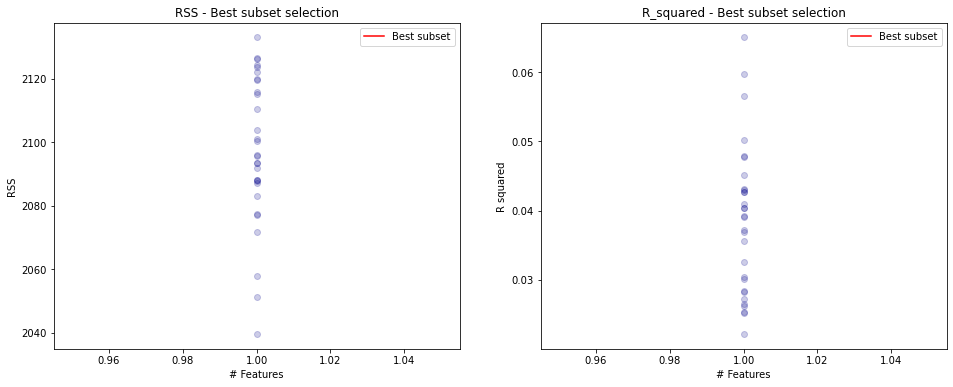

In [61]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.num_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.num_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.num_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.num_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()